In [1]:
from functions import *
from agent import Noveltor
from environments import gridworld
import matplotlib.pyplot as plt
import numpy as np
from tqdm.auto import tqdm

In [2]:
from math import floor

### Define the GridWorld

(Creating Willemsen Gridworld)


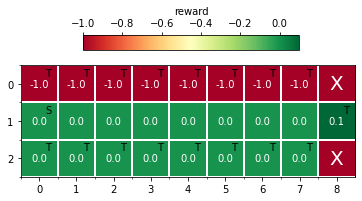

In [3]:
# Create the gridworld, and set cell values to equal rewards
print('(Creating Willemsen Gridworld)')
grid = np.ones((3, 9)) * -1
grid[1,:8] = 0
grid[1, 8] = 0.1
grid[2, :8] = 0
terminal_state = []
for i in [0,2]:
    for j in range(8):
        terminal_state.append([i,j])
terminal_state.append([1,8])
terminal_state = np.array(terminal_state)
initial_state = np.array([1, 0])
blacked_state = np.array([[0, 8],[2, 8]])

fig, ax, im, cb = plot_gridworld(grid, terminal_state, initial_state, blacked_state, fig=None, ax=None, show=True)

### Initialize Parameters

In [24]:
n_episodes = 3
max_steps = 40
gamma = 0.8
alpha = 0.1
epsilon = 0.05

Learn = True
batch_size = 1

### Generate Trajectories

In [25]:
env = gridworld(grid, terminal_state, initial_state, blacked_state, max_steps)
agent = Noveltor(alpha, epsilon, gamma, batch_size, initial_state, s_prior=None, learn=True)

epsilons = np.flip(np.linspace(0.05, 1, n_episodes))
trajectories = []

for i in tqdm(range(n_episodes)):
    trajectory = run_trajectory(env, agent, epsilons[i], abstract=False)
    
    trajectories.append(trajectory)

  0%|          | 0/3 [00:00<?, ?it/s]

In [26]:
agent.q_table

{'[1 0]': {'up': 0, 'down': 0, 'left': 0, 'right': 0.0},
 '[2 0]': {'up': 0, 'down': 0, 'left': 0, 'right': 0},
 '[1 1]': {'up': -1.0, 'down': 0, 'left': 0, 'right': 0},
 '[0 1]': {'up': 0, 'down': 0, 'left': 0, 'right': 0},
 '[0 0]': {'up': 0, 'down': 0, 'left': 0, 'right': 0}}

### Process Trajectories

In [27]:
returns_table = cumulative_table(trajectories, gamma, Qpi_sa, agent.q_table)
rho = state_dist(agent.visits)
abs_action = action_abstraction(returns_table, rho)
sa_values, a_values, bias_squared = action_abstraction_bias(returns_table, abs_action)
heatmap = generate_heatmap(grid, rho)
heatmapQ = generate_heatmap(grid, agent.q_table, aggf=lambda x: max(v for v in x.values()))
n_maps = {}
for a in agent.actions:
    n_maps[a] = generate_heatmap(grid, agent.n_table, aggf=lambda x: x[a])
    
nt_maps = {}
for a in agent.actions:
    hm = np.copy(grid)*0
    for state, actions in agent.n_visits.items():
        if a in list(actions.keys()):
            hm[int(state[1]), int(state[3])] = actions[a]
    nt_maps[a] = hm

### Plot Results

(Plotting 1 of 1)


<IPython.core.display.Javascript object>


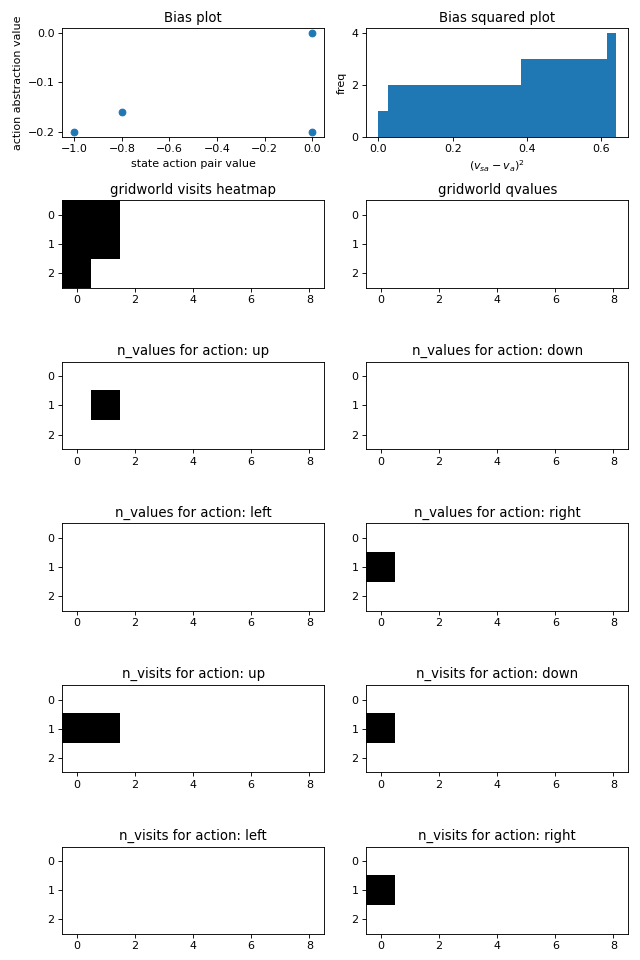

In [34]:
# First plot
%matplotlib notebook
print('(Plotting 1 of 1)')
fig, ax = plt.subplots(ncols=2, nrows=6, figsize=(8, 12))

ax[0, 0].scatter(sa_values, a_values)
ax[0, 0].set_title('Bias plot')
ax[0, 0].set_xlabel('state action pair value')
ax[0, 0].set_ylabel('action abstraction value')
#ax[0, 0].set_ylim((0, 40))

ax[0, 1].hist(bias_squared, cumulative=True, bins=25)
ax[0, 1].set_title('Bias squared plot')
ax[0, 1].set_xlabel(r'$(v_{sa} - v_{a})^2$')
ax[0, 1].set_ylabel('freq')
# plt.ylim((0, 40))

ax[1, 0].imshow(heatmap, cmap='binary')
ax[1, 0].set_title('gridworld visits heatmap')

ax[1, 1].imshow(heatmapQ, cmap='binary')
ax[1, 1].set_title('gridworld qvalues')

ind = 4
for action, n_map in n_maps.items():
    x,y = (floor(ind/2), ind%2)
    ax[x,y].imshow(n_maps[action], cmap='binary')
    ax[x,y].set_title('n_values for action: %s' % action)
    ind += 1

for action, n_map in n_maps.items():
    x,y = (floor(ind/2), ind%2)
    ax[x,y].imshow(nt_maps[action], cmap='binary')
    ax[x,y].set_title('n_visits for action: %s' % action)
    ind += 1

plt.tight_layout()
plt.show()